# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

## 1.1 Background
According to a 2018 U.S. Census Bureau report, in 2035 “there will be 78 million people 65 years and older compared to 76.4 million under the age of 18.” [1]. With the growing aging population, the need for adult day care is also growing. Adult day care is basically the same as child care, except that here we deal with adults. People who attend adult day care live at home and can take care of themselves. They are looking for a place to go where they can spend their time and meet other people. It has been known that recreational activities and social stimulation improve or maintain physical and cognitive functions, so this will help them stay active and healthier longer, both physically and mentally. At the adult day care centers seniors will be provided with meals, have activities, do exercises, socialize, and some would provide transportation to and from the home.

[1].	https://news.usc.edu/143675/aging-u-s-population-unique-health-challenges/

## 1.2 Problem
In this project we will try to find an optimal location for an adult day care center in the Queens Borough of New York City whose main focus will be on recreational activities and social stimulation for the elderly population who would otherwise stay at home alone. The recreational activities would include: daily exercise regimes in a local park (tai chi, yoga, pilates, walking), while the social stimulation would consists of arts and crafts, music, games (bingo, scrabble, etc.) and general socialization and conversations to form friendly relationships. Only in case of a bad weather daily exercise regimes would be performed indoor. The center would have a nurse on-site so that participants’ vital signs can be checked and evaluated regularly. The center would also fill prescriptions at a local pharmacy if participants request such service. In addition, the center would provide healthy meals and snacks and transportation to participants.
Since the center would provide daily exercise regimes, we prefer locations as close to parks as possible. To avoid competition, we don't want to be in a proximity of existing adult day care centers. To be able to fill prescriptions we want to be in a proximity of a pharmacy.

Specifically, since we want to be as close to parks as possible our problem will be to identify parks in Queens satisfying the following 2 conditions:

1. No existing adult day care center within 1 km of the park latitude and longitude coordinates.
2. At least one pharmacy within 2 km of the park latitude and longitude coordinates.

## 1.3 Interest
This report will be targeted to stakeholders interested in opening such adult day care center in Queens. It may be of interest also to entrepreneurs who want to start adult day care business. According to the Administration on Aging, one out of every eight Americans is over the age of 65 [2]. This increase of the senior population in America offers excellent opportunities in the adult day care industry.

[2].	https://bizfluent.com/about-5479617-requirements-adult-day-care-business.html

## Data  <a name="data"></a>

Based on definition of our problem, we need locations of parks, pharmacies and adult day care centers in Queens, New York City. 
1. To limit neighborhoods to Queens we will use New York City Neighborhood dataset ( https://geo.nyu.edu/catalog/nyu_2451_34572 ). This dataset contains 5 boroughs and neighborhoods that exist in each borough as well as the latitude and longitude coordinates of each neighborhood. We can conveniently access this data from this web address: https://cocl.us/new_york_dataset. 
2. Foursquare location data will be used to get locations of parks and pharmacies venues in Queens. 
3. Since the Foursquare data does not list adult day care centers in Queens we will obtain locations of these centers from this https://data.cityofnewyork.us/Social-Services/Department-for-the-Aging-DFTA-Social-Adult-Day-Car/32cj-z7va dataset on the NYC OpenData website. This dataset is a listing of registered agencies providing Social Adult Day Care Services with hours of operation in New York City. It currently has 328 rows and 34 columns. We will limit this data to the Queens Borough locations.

__Before we explore the data let us first import needed libraries__

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

__Since we need to limit our data to Queens we will use geopy library to get the latitude and longitude values of Queens__

In [14]:
#The geograpical coordinate of Queens are 40.6524927, -73.7914214158161.
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.6524927, -73.7914214158161.


__1. get New York City Neighborhood dataset and limit neighborhoods to Queens__

In [15]:
import io
url_ny = 'https://cocl.us/new_york_dataset'
s=requests.get(url_ny).content
ny_json_dat=json.load(io.StringIO(s.decode('utf-8')))

In [16]:
# ny_json_dat is a dictinary so let's see how many keys are in this dictionary
all_keys = ny_json_dat.keys()
print('There are', len(all_keys), 'keys in ny_json_dat:')
print(all_keys)

#display keys and respective values (for features key e display only first element)
for key in all_keys:
    if key == 'features':
        print(key,':',ny_json_dat[key][0])
    else:
        print(key,':',ny_json_dat[key])

There are 5 keys in ny_json_dat:
dict_keys(['type', 'totalFeatures', 'features', 'crs', 'bbox'])
type : FeatureCollection
totalFeatures : 306
features : {'type': 'Feature', 'id': 'nyu_2451_34572.1', 'geometry': {'type': 'Point', 'coordinates': [-73.84720052054902, 40.89470517661]}, 'geometry_name': 'geom', 'properties': {'name': 'Wakefield', 'stacked': 1, 'annoline1': 'Wakefield', 'annoline2': None, 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.84720052054902, 40.89470517661, -73.84720052054902, 40.89470517661]}}
crs : {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}
bbox : [-74.2492599487305, 40.5033187866211, -73.7061614990234, 40.9105606079102]


__get a list of the neighborhoods__

In [17]:
ny_neighborhoods_data = ny_json_dat['features']

__Transform the data into a pandas dataframe and loop through the data and fill the dataframe one row at a time__

In [18]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in ny_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods[['Borough','Neighborhood']].groupby('Borough').count()

,Neighborhood
Borough,
Bronx,52
Brooklyn,70
Manhattan,40
Queens,81
Staten Island,63


__limit neighborhoods data to the Queens borough__

In [19]:
queens_neighborhoods=neighborhoods[neighborhoods['Borough']=='Queens']
queens_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
129,Queens,Astoria,40.768509,-73.915654
130,Queens,Woodside,40.746349,-73.901842
131,Queens,Jackson Heights,40.751981,-73.882821
132,Queens,Elmhurst,40.744049,-73.881656
133,Queens,Howard Beach,40.654225,-73.838138


__2. to get locations of parks and pharmacies venues in Queens we will use the Foursquare location data in combination with the above queens_neighborhoods dataframe__

__Define Foursquare Credentials and Version__

In [1]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20191019' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
CLIENT_SECRET:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


__define getNearbyVenus function__

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("processing neighborhhod: ", name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

__get the top 100 venues that are within a radius of 500 meters of given coordinates for all Queens neighborhoods__

In [23]:
LIMIT = 100
radius=500

queens_venues = getNearbyVenues(names=queens_neighborhoods['Neighborhood'],
                                   latitudes=queens_neighborhoods['Latitude'],
                                   longitudes=queens_neighborhoods['Longitude']
                                  )

processing neighborhhod:  Astoria
processing neighborhhod:  Woodside
processing neighborhhod:  Jackson Heights
processing neighborhhod:  Elmhurst
processing neighborhhod:  Howard Beach
processing neighborhhod:  Corona
processing neighborhhod:  Forest Hills
processing neighborhhod:  Kew Gardens
processing neighborhhod:  Richmond Hill
processing neighborhhod:  Flushing
processing neighborhhod:  Long Island City
processing neighborhhod:  Sunnyside
processing neighborhhod:  East Elmhurst
processing neighborhhod:  Maspeth
processing neighborhhod:  Ridgewood
processing neighborhhod:  Glendale
processing neighborhhod:  Rego Park
processing neighborhhod:  Woodhaven
processing neighborhhod:  Ozone Park
processing neighborhhod:  South Ozone Park
processing neighborhhod:  College Point
processing neighborhhod:  Whitestone
processing neighborhhod:  Bayside
processing neighborhhod:  Auburndale
processing neighborhhod:  Little Neck
processing neighborhhod:  Douglaston
processing neighborhhod:  Glen 

__focus on Queens pharmacies and parks__

In [24]:
queens_pharmacies_and_parks = queens_venues[queens_venues['Venue Category'].isin(['Pharmacy','Park' ])].reset_index(drop=True)
queens_pharmacies_and_parks.shape

(78, 7)

__let us display all pharmacies and parks in Queens__

In [25]:
queens_pharmacies_and_parks

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Woodside,40.746349,-73.901842,Rite Aid,40.744682,-73.903707,Pharmacy
1,Woodside,40.746349,-73.901842,Duane Reade,40.745286,-73.904236,Pharmacy
2,Jackson Heights,40.751981,-73.882821,Rite Aid,40.750023,-73.883977,Pharmacy
3,Jackson Heights,40.751981,-73.882821,Rite Aid,40.755766,-73.882127,Pharmacy
4,Elmhurst,40.744049,-73.881656,Broadway Park,40.740795,-73.885517,Park
5,Howard Beach,40.654225,-73.838138,Rite Aid,40.656352,-73.839615,Pharmacy
6,Howard Beach,40.654225,-73.838138,Duane Reade,40.651612,-73.838626,Pharmacy
7,Corona,40.742382,-73.856825,William F. Moore Park ('Spaghetti Park'),40.743666,-73.855443,Park
8,Forest Hills,40.725264,-73.844475,Yellowstone Park,40.726251,-73.847759,Park
9,Forest Hills,40.725264,-73.844475,MacDonald Park,40.722239,-73.847141,Park


__3. obtain locations of adult day care centers in Queens__

In [26]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    'IBM_API_KEY_ID': 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    'FILE': 'Department_for_the_Aging__DFTA___-_Social_Adult_Day_Care_Services.csv'
}

In [27]:
from ibm_botocore.client import Config
import ibm_boto3
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In [28]:
from ibm_botocore.client import Config
import ibm_boto3
def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')
        
download_file_cos(credentials,'Social_Adult_Day_Care_Services.csv', 'Department_for_the_Aging__DFTA___-_Social_Adult_Day_Care_Services.csv')

File Downloaded


__There are 328 adult day care centers in New York City__

In [29]:
import pandas as pd
import csv
# Read data from csv file
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv
adult_care_services_data = pd.read_csv("Social_Adult_Day_Care_Services.csv") 
# Preview the first 5 lines of the loaded data 
adult_care_services_data.shape

(328, 34)

__limit this data to adult day care centers in Queens__

In [30]:
queens_adult_care_services_data=adult_care_services_data[adult_care_services_data["Borough"] == 'Queens']
queens_adult_care_services_data.shape

(121, 34)

__display first 5 rows of adult day care centers data in Queens__

In [31]:
queens_adult_care_services_data.reset_index(drop=True, inplace=True)
queens_adult_care_services_data.head()

,ProviderType,DFTA ID,ProgramName,SponsorName,ProgramAddress,ProgramCity,ProgramState,Postcode,Borough,ProgramPhone,DFTA Funded,MonHourOpen,MonHourClose,TueHourOpen,TueHourClose,WedHourOpen,WedHourClose,ThuHourOpen,ThuHourClose,FriHourOpen,FriHourClose,SatHourOpen,SatHourClose,SunHourOpen,SunHourClose,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location 1
0,SOCIAL ADULT DAY CARE SERVICES,S39201,"QUEENS BOROUGH ADULT DAY CARE, LLC","Queens Borough Adult Day Care, Llc",137-08 31ST ROAD 1 FLOOR,FLUSHING,NY,11354,Queens,347-732-4588,N,08:30,06:30,08:30,06:30,08:30,06:30,08:30,06:30,08:30,06:30,08:30,06:30,00:00,00:00,40.769719,-73.831280,407,20,88901,4537661.0,4.044108e+09,Flushing,"(40.769719, -73.83128)"
1,SOCIAL ADULT DAY CARE SERVICES,S4301,"UNICARE ADULT DAYCARE, INC.","Unicare Adult Daycare, Inc.",176-60 UNION TURNPIKE SUITE 115,FRESH MEADOWS,NY,11366,Queens,347-770-0466,N,09:30,03:30,09:30,03:30,09:30,03:30,09:30,03:30,09:30,03:30,00:00,00:00,00:00,00:00,40.725856,-73.791441,408,24,1277,4155422.0,4.072270e+09,Jamaica Estates-Holliswood,"(40.725856, -73.791441)"
2,SOCIAL ADULT DAY CARE SERVICES,S37801,"EVERGREEN ADULT DAYCARE IN NY, INC.","Evergreen Adult Daycare In Ny, Inc.",37-10 149 PLACE 1A,FLUSHING,NY,11354,Queens,718-321-2112,N,07:00,05:00,07:00,05:00,07:00,05:00,07:00,05:00,07:00,05:00,07:00,01:00,00:00,00:00,40.765159,-73.816107,407,20,1157,4483670.0,4.050178e+09,Murray Hill,"(40.765159, -73.816107)"
3,SOCIAL ADULT DAY CARE SERVICES,S52701,CAREFIRST SOCIAL DAY CARE INC.,Carefirst Social Day Care Inc.,135-10 35TH AVE UNIT A,FLUSHING,NY,11354,Queens,732-312-5713,N,09:00,05:00,09:00,05:00,09:00,05:00,09:00,05:00,09:00,05:00,09:00,05:00,09:00,05:00,40.764504,-73.831531,407,20,869,4112140.0,4.049598e+09,Flushing,"(40.764504, -73.831531)"
4,SOCIAL ADULT DAY CARE SERVICES,S46401,CRYSTAL ADULT SOCIAL DAY CARE LLC,Crystal Adult Social Day Care Llc,138-31 QUEENS BLVD GROUND FLOOR,JAMAICA,NY,11435,Queens,718-642-0011,N,08:30,02:00,08:30,02:00,08:30,02:00,08:30,02:00,08:30,02:00,00:00,00:00,08:30,02:00,40.708216,-73.818028,408,24,214,4206512.0,4.096490e+09,Briarwood-Jamaica Hills,"(40.708216, -73.818028)"


__Now we have all the data we need:__
1.  _Locations of pharmacies and parks in Queens._ 
    Remember to derive this data we used the New York City Neighborhood dataset and limited this set to Queens neighborhoods and then used 
    the Foursquare location data to obtain needed locations of pharmacies and parks.
2. _Locations of adult day care centers in Queens._

This concludes the data gathering phase.

We are now ready to use this data for analysis to produce the report on an optimal location for an adult day care center in the Queens Borough of New York City.

## Methodology <a name="methodology"></a>

In this project we will try to find an optimal location for an adult day care center in the Queens Borough of New York City whose main focus will be on recreational activities and social stimulation for the elderly population who would otherwise stay at home alone. 


Since the center would provide daily exercise regimes, we prefer locations as close to parks as possible.  
To avoid competition, we don't want to be in a proximity of existing adult day care centers.  
To be able to fill prescriptions we want to be in a proximity of a pharmacy.
Specifically, since we want to be as close to parks as possible our problem will be to identify parks in Queens satisfying the following 2 conditions:

1. No existing adult day care center within 1 km of the park latitude and longitude coordinates.
2. At least one pharmacy within 2 km of the park latitude and longitude coordinates.

The distance calculation between two Global Positioning System (GPS) locations is a core of our problem.
To calculate distance between two GPS locations  we can't use Euclidean distance since we have to deal with a sphere, or an oblate spheroid to be exact.  
We need to look at geodesic distances.   
There are different ways to handle this calculation problem. We will use Haversine formula ( https://en.wikipedia.org/wiki/Haversine_formula ) to complete the task.  
The Python implementation of this formula can be found here: https://janakiev.com/blog/gps-points-distance-python/ .

Our approach will be 3 steps approach.  
First, we will cluster pharmacies and parks in Queens using k-means clustering method.  
Our intuition here is that an optimal location for an adult day care center would be probably around a park that belongs to a cluster where parks and pharmacies are mixed together.  
So clustering will provide a first cut of potential candidate parks.  
To determine k in k-means clustering we will use "elbow" method ( https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f ).  
The inertia attribute will be used to identify the sum of squared distances of samples to the nearest cluster center.  
As k increases, the sum of squared distance tends to zero. If the plot looks like an arm, then the elbow on the arm is optimal k.  

Second, for each park will proceed, using Haversine formula, to the distance calculation between the park and all pharmacies in Queens and the park and all existing adult day care centers in Queens.  
We'll focus on parks satisfying above two conditions (at least one pharmacy within 2 km of the park and no existing adult day care center within 1 km of the park).  
For each respective park satisfying these conditions we will count the number of pharmacies within 2 km of the park.  

And finally third, for these parks in Queens we'll produce a heat map based on count of respective pharmacies to graphically display promising locations.  
These park locations will be presented to stakeholders as a starting point for stakeholders final 'street level' exploration to determine the optimal adult day care center location.

## Analysis <a name="analysis"></a>

Let us perform some basic explanatory data analysis.

__For each of the above 3 datasets (queens_neighborhoods, queens_pharmacies_and_parks, and queens_adult_care_services_data) we will display shape, counts of total null values, and count of total NaN values__

In [32]:
print("For queens_neighborhoods dataset shape is",queens_neighborhoods.shape, ", total number of null values is", queens_neighborhoods.isnull().sum().sum(), ", total number of NaN values is" , queens_neighborhoods.isna().sum().sum())

For queens_neighborhoods dataset shape is (81, 4) , total number of null values is 0 , total number of NaN values is 0


In [33]:
print("For queens_pharmacies_and_parks dataset shape is",queens_pharmacies_and_parks.shape, ", total number of null values is", queens_pharmacies_and_parks.isnull().sum().sum(), ", total number of NaN values is" , queens_pharmacies_and_parks.isna().sum().sum())

For queens_pharmacies_and_parks dataset shape is (78, 7) , total number of null values is 0 , total number of NaN values is 0


In [34]:
print("For queens_adult_care_services_data dataset shape is",queens_adult_care_services_data.shape, ", total number of null values is", queens_adult_care_services_data.isnull().sum().sum(), ", total number of NaN values is" , queens_adult_care_services_data.isna().sum().sum())

For queens_adult_care_services_data dataset shape is (121, 34) , total number of null values is 0 , total number of NaN values is 0


__Our datasets look good, no surprises here.__  
As we can see there are 81 neighborhoods in Queens, 78 pharmacies and parks, and quite a lot of adult day care service centers (121).

__In addition, queens_venues dataset which we limited to Pharmacies and Parks venues to create queens_pharmacies_and_parks dataset looks also good__

In [35]:
print("For queens_venues dataset shape is",queens_venues.shape, ", total number of null values is", queens_venues.isnull().sum().sum(), ", total number of NaN values is" , queens_venues.isna().sum().sum())

For queens_venues dataset shape is (2128, 7) , total number of null values is 0 , total number of NaN values is 0


__Let's display top 30 venues in Queens to see that top 3 venues are Pizza Place, Deli/Bodega, and Chinese Restaurant.__  
Pharmacies are on 7th place and Parks are 18th place.

In [36]:
queens_venues_stats = queens_venues[['Neighborhood','Venue Category']].groupby('Venue Category').count()
queens_venues_stats.rename(columns={'Neighborhood':'Cnt'}, inplace=True)
queens_venues_stats.sort_values(by="Cnt",ascending=False, inplace=True)
queens_venues_stats.head(30)

,Cnt
Venue Category,
Pizza Place,81
Deli / Bodega,74
Chinese Restaurant,69
Bakery,56
Donut Shop,55
Bank,48
Pharmacy,47
Bar,45
Korean Restaurant,42


__Summary Statistics of numeric columns show data consistency for all 3 datasets.__  
Mean values of Latitude and Longitude are almost equal to the geographical coordinate of Queens: 40.6524927, -73.7914214158161.

In [37]:
queens_neighborhoods.describe()

,Latitude,Longitude
count,81.000000,81.000000
mean,40.706424,-73.824131
std,0.062189,0.061892
min,40.557401,-73.953868
25%,40.675211,-73.862525
50%,40.723825,-73.820878
75%,40.749441,-73.776133
max,40.792781,-73.708847


In [38]:
queens_pharmacies_and_parks.describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
count,78.000000,78.000000,78.000000,78.000000
mean,40.714734,-73.830720,40.714666,-73.830391
std,0.045832,0.056763,0.045178,0.057141
min,40.576156,-73.953868,40.578282,-73.953225
25%,40.690609,-73.858110,40.692995,-73.860513
50%,40.725264,-73.841278,40.722794,-73.839849
75%,40.745652,-73.792938,40.744546,-73.788362
max,40.784903,-73.715481,40.788130,-73.714218


In [39]:
queens_adult_care_services_data.describe()

,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,1.210000e+02,1.210000e+02
mean,11392.396694,40.728075,-73.820131,408.099174,23.512397,24717.429752,4.299619e+06,4.067062e+09
std,114.581083,0.049462,0.039433,2.995566,4.322645,42680.541070,2.000346e+05,3.837966e+07
min,11004.000000,40.577862,-73.925909,402.000000,19.000000,4.000000,4.000000e+06,4.001890e+09
25%,11354.000000,40.709001,-73.832599,407.000000,20.000000,745.000000,4.119280e+06,4.049718e+09
50%,11358.000000,40.749598,-73.827413,407.000000,21.000000,871.000000,4.229858e+06,4.051058e+09
75%,11419.000000,40.761399,-73.805281,409.000000,27.000000,18101.000000,4.531582e+06,4.089100e+09
max,11694.000000,40.776381,-73.710464,414.000000,32.000000,157902.000000,4.607563e+06,4.162280e+09


__Having established that we really have good data, let's do one hot encoding of the Venue Category categorical variable for the queens_pharmacies_and_parks dataset__  
One hot encoding is a process by which categorical variables are converted into a form that could be provided to Machine learning algorithms to do a better job in prediction.  
Remember we need to cluster pharmacies and parks in Queens using k-means clustering method.

In [40]:
# one hot encoding
queens_pharmacies_and_parks_onehot = pd.get_dummies(queens_pharmacies_and_parks[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_pharmacies_and_parks_onehot['Neighborhood'] = queens_pharmacies_and_parks['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_pharmacies_and_parks_onehot.columns[-1]] + list(queens_pharmacies_and_parks_onehot.columns[:-1])
queens_pharmacies_and_parks_onehot = queens_pharmacies_and_parks_onehot[fixed_columns]

queens_pharmacies_and_parks_onehot.head()

,Neighborhood,Park,Pharmacy
0,Woodside,0,1
1,Woodside,0,1
2,Jackson Heights,0,1
3,Jackson Heights,0,1
4,Elmhurst,1,0


Now we group by Neighborhood and apply mean

In [41]:
queens_pharmacies_and_parks_grouped = queens_pharmacies_and_parks_onehot.groupby('Neighborhood').mean().reset_index()
queens_pharmacies_and_parks_grouped.head()

,Neighborhood,Park,Pharmacy
0,Auburndale,0.0,1.0
1,Bay Terrace,0.0,1.0
2,Bayside,0.0,1.0
3,Bayswater,1.0,0.0
4,Belle Harbor,0.0,1.0


Since we only care aboout 2 types of venues (Parks and Pharmacies) we will identify  the 1st and the 2nd most common venue for each neighborhood

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 2

indicators = ['st', 'nd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_pharmacies_and_parks_grouped['Neighborhood']

for ind in np.arange(queens_pharmacies_and_parks_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_pharmacies_and_parks_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue
0,Auburndale,Pharmacy,Park
1,Bay Terrace,Pharmacy,Park
2,Bayside,Pharmacy,Park
3,Bayswater,Park,Pharmacy
4,Belle Harbor,Pharmacy,Park


__Now we are ready to apply "elbow" method to  determine k for k-means clustering:__ https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f 

In [43]:
Sum_of_squared_distances = []

queens_pharmacies_and_parks_grouped_clustering = queens_pharmacies_and_parks_grouped.drop('Neighborhood', 1)

K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(queens_pharmacies_and_parks_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
Sum_of_squared_distances

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cl

[17.433333333333334,
 2.33668582375479,
 0.29027777777777775,
 0.05555555555555556,
 0.011111111111111113,
 6.162975822039155e-32,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
Below is a plot of sum of squared distances for k in the range specified above. Since the plot looks like an arm, then the elbow on the arm is optimal k

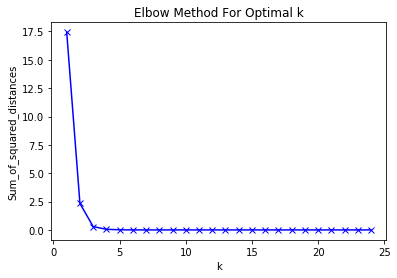

In [45]:
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plt.show()

__In the plot above the elbow is at k=3 indicating that the optimal k for the queens_pharmacies_and_parks_grouped dataset is 3__  
Now we can cluster pharmacies and parks in Queens using k-means clustering method with k=3.

In [46]:
# set number of clusters
kclusters = 3

queens_pharmacies_and_parks_grouped_clustering = queens_pharmacies_and_parks_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_pharmacies_and_parks_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 1, 2, 2, 0, 2, 0, 1, 0, 1, 0],
      dtype=int32)

__Let us add clustering labels to our queens_pharmacies_and_parks_merged dataset and display clusters on a folium map__

In [47]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

queens_pharmacies_and_parks_merged = queens_pharmacies_and_parks

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
queens_pharmacies_and_parks_merged = queens_pharmacies_and_parks_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

queens_pharmacies_and_parks_merged.head() # check the 8th column for Cluster Labels!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
0,Woodside,40.746349,-73.901842,Rite Aid,40.744682,-73.903707,Pharmacy,0,Pharmacy,Park
1,Woodside,40.746349,-73.901842,Duane Reade,40.745286,-73.904236,Pharmacy,0,Pharmacy,Park
2,Jackson Heights,40.751981,-73.882821,Rite Aid,40.750023,-73.883977,Pharmacy,0,Pharmacy,Park
3,Jackson Heights,40.751981,-73.882821,Rite Aid,40.755766,-73.882127,Pharmacy,0,Pharmacy,Park
4,Elmhurst,40.744049,-73.881656,Broadway Park,40.740795,-73.885517,Park,1,Park,Pharmacy


In [48]:
# create map
f = folium.Figure(width=1000, height=500)
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12).add_to(f)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_pharmacies_and_parks_merged['Venue Latitude'], queens_pharmacies_and_parks_merged['Venue Longitude'], queens_pharmacies_and_parks_merged['Venue'], queens_pharmacies_and_parks_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

__Interestingly we have one cluster with parks only, one with pharmacies only and one with pharmacies and parks listed below__

__Pharmacies cluster__

In [52]:
queens_pharmacies_and_parks_merged.loc[queens_pharmacies_and_parks_merged['Cluster Labels'] == 0]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
0,Woodside,40.746349,-73.901842,Rite Aid,40.744682,-73.903707,Pharmacy,0,Pharmacy,Park
1,Woodside,40.746349,-73.901842,Duane Reade,40.745286,-73.904236,Pharmacy,0,Pharmacy,Park
2,Jackson Heights,40.751981,-73.882821,Rite Aid,40.750023,-73.883977,Pharmacy,0,Pharmacy,Park
3,Jackson Heights,40.751981,-73.882821,Rite Aid,40.755766,-73.882127,Pharmacy,0,Pharmacy,Park
5,Howard Beach,40.654225,-73.838138,Rite Aid,40.656352,-73.839615,Pharmacy,0,Pharmacy,Park
6,Howard Beach,40.654225,-73.838138,Duane Reade,40.651612,-73.838626,Pharmacy,0,Pharmacy,Park
20,Ridgewood,40.708323,-73.901435,Rite Aid,40.708905,-73.905848,Pharmacy,0,Pharmacy,Park
27,Ozone Park,40.680708,-73.843203,Rite Aid,40.680039,-73.842190,Pharmacy,0,Pharmacy,Park
28,Ozone Park,40.680708,-73.843203,CVS pharmacy,40.681177,-73.841730,Pharmacy,0,Pharmacy,Park
29,Ozone Park,40.680708,-73.843203,Cross Bay Chemist,40.684691,-73.844689,Pharmacy,0,Pharmacy,Park


__Parks cluster__

In [53]:
queens_pharmacies_and_parks_merged.loc[queens_pharmacies_and_parks_merged['Cluster Labels'] == 1]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
4,Elmhurst,40.744049,-73.881656,Broadway Park,40.740795,-73.885517,Park,1,Park,Pharmacy
7,Corona,40.742382,-73.856825,William F. Moore Park ('Spaghetti Park'),40.743666,-73.855443,Park,1,Park,Pharmacy
15,Richmond Hill,40.697947,-73.831833,Lt. Frank McConnell Park,40.694270,-73.829010,Park,1,Park,Pharmacy
16,Sunnyside,40.740176,-73.926916,"Thomas P. Noonan, Jr. Playground",40.741053,-73.922213,Park,1,Park,Pharmacy
30,South Ozone Park,40.668550,-73.809865,Back Streets Park (Officer Edward Byrn Park),40.667846,-73.806453,Park,1,Park,Pharmacy
31,South Ozone Park,40.668550,-73.809865,Pals Oval Park,40.668634,-73.805878,Park,1,Park,Pharmacy
32,South Ozone Park,40.668550,-73.809865,Back Street Park,40.666542,-73.806407,Park,1,Park,Pharmacy
48,Hollis,40.711243,-73.759250,Kings Park,40.712344,-73.764469,Park,1,Park,Pharmacy
49,Hollis,40.711243,-73.759250,Jamaica Park,40.712351,-73.764478,Park,1,Park,Pharmacy
51,Springfield Gardens,40.666230,-73.760421,Springfield Park,40.665932,-73.758064,Park,1,Park,Pharmacy


__Pharmacies and Parks cluster__

In [54]:
queens_pharmacies_and_parks_merged.loc[queens_pharmacies_and_parks_merged['Cluster Labels'] == 2]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
8,Forest Hills,40.725264,-73.844475,Yellowstone Park,40.726251,-73.847759,Park,2,Pharmacy,Park
9,Forest Hills,40.725264,-73.844475,MacDonald Park,40.722239,-73.847141,Park,2,Pharmacy,Park
10,Forest Hills,40.725264,-73.844475,Walgreens,40.724004,-73.847911,Pharmacy,2,Pharmacy,Park
11,Forest Hills,40.725264,-73.844475,CVS pharmacy,40.721396,-73.843421,Pharmacy,2,Pharmacy,Park
12,Kew Gardens,40.705179,-73.829819,CVS pharmacy,40.703557,-73.824861,Pharmacy,2,Park,Pharmacy
13,Kew Gardens,40.705179,-73.829819,Eight Oaks Triangle,40.707226,-73.827127,Park,2,Park,Pharmacy
14,Kew Gardens,40.705179,-73.829819,LIRR Metropolitan Yard,40.703840,-73.824317,Park,2,Park,Pharmacy
17,Maspeth,40.725427,-73.896217,CVS pharmacy,40.727184,-73.892861,Pharmacy,2,Pharmacy,Park
18,Maspeth,40.725427,-73.896217,Eagle pharmacy,40.722987,-73.900637,Pharmacy,2,Pharmacy,Park
19,Maspeth,40.725427,-73.896217,Whitefish Triangle Park,40.726517,-73.901752,Park,2,Pharmacy,Park


In the remaining parts of the Analysis section we will analyze the queens_adult_care_services_data dataset with respect to joining this dataframe with the queens_pharmacies_and_parks_merged dataset.  
We will join the queens_adult_care_services_data dataset with the queens_pharmacies_and_parks_merged dataset in order to see how the adult day care centers are distributed across above 3 clusters.  
Then for each park will proceed, using Haversine formula to the distance calculation between the park and all pharmacies in Queens and the park and all existing adult day care centers in Queens.  
We will create a final dataframe that will contain for each park respective counts of pharmacies within 2 km from the park and counts of adult day care centers within 1 km from the park along with respective cluster labels.  
Finally, we will list potential "solution" parks with the adult day care centers count = 0 and the pharmacy count > 0 and  
produce a heat map based on the count of respective pharmacies to graphically display promising locations.

__Now let's analyze the queens_adult_care_services_data dataset with respect to joining it with the queens_pharmacies_and_parks_merged dataset__  
We will print lists of neighborhoods for both datasets.

In [55]:
queens_pharmacies_and_parks_neigh_list = sorted(queens_pharmacies_and_parks_merged["Neighborhood"].unique().tolist())
print("queens_pharmacies_and_parks_neigh_list:",queens_pharmacies_and_parks_neigh_list)

queens_pharmacies_and_parks_neigh_list: ['Auburndale', 'Bay Terrace', 'Bayside', 'Bayswater', 'Belle Harbor', 'Cambria Heights', 'College Point', 'Corona', 'Douglaston', 'Edgemere', 'Elmhurst', 'Forest Hills', 'Forest Hills Gardens', 'Fresh Meadows', 'Glen Oaks', 'Hillcrest', 'Hollis', 'Howard Beach', 'Hunters Point', 'Jackson Heights', 'Jamaica Center', 'Jamaica Hills', 'Kew Gardens', 'Laurelton', 'Lefrak City', 'Maspeth', 'Middle Village', 'Oakland Gardens', 'Ozone Park', 'Pomonok', 'Queensboro Hill', 'Queensbridge', 'Rego Park', 'Richmond Hill', 'Ridgewood', 'Rochdale', 'Rockaway Park', 'Rosedale', 'Somerville', 'South Ozone Park', 'Springfield Gardens', 'Sunnyside', 'Sunnyside Gardens', 'Woodhaven', 'Woodside']


In [56]:
# NTA column contains Neighborhood information
queens_adult_care_serv_neigh_list = sorted(queens_adult_care_services_data["NTA"].unique().tolist())
print("queens_adult_care_serv_neigh_list:",queens_adult_care_serv_neigh_list)

queens_adult_care_serv_neigh_list: ['Bayside-Bayside Hills', 'Bellerose', 'Breezy Point-Belle Harbor-Rockaway Park-Broad Channel', 'Briarwood-Jamaica Hills', 'College Point', 'Corona', 'East Elmhurst', 'East Flushing', 'Elmhurst', 'Elmhurst-Maspeth', 'Far Rockaway-Bayswater', 'Flushing', 'Forest Hills', 'Ft. Totten-Bay Terrace-Clearview', 'Glen Oaks-Floral Park-New Hyde Park', 'Hammels-Arverne-Edgemere', 'Hollis', 'Hunters Point-Sunnyside-West Maspeth', 'Jamaica', 'Jamaica Estates-Holliswood', 'Kew Gardens', 'Murray Hill', 'North Corona', 'Pomonok-Flushing Heights-Hillcrest', 'Queens Village', 'Queensboro Hill', 'Rego Park', 'Richmond Hill', 'Ridgewood', 'South Ozone Park', 'St. Albans', 'Woodhaven']


__We see that some neighborhood names are slightly different, for example Elmhurst-Maspeth vs. Elmhurst__  
So for the queens_adult_care_services_data we'll split the NTA column on "-" and take the first part of the split as the neighborhood name.  
We'll limit the queens_adult_care_services_data to ProgramName, Latitude, Longitude, and NTA columns and create Neighborhood column with the NTA split information.

In [57]:
queens_adult_care_services_massaged = queens_adult_care_services_data[["ProgramName","Latitude","Longitude","NTA"]]
queens_adult_care_services_massaged["Neighborhood"]= queens_adult_care_services_massaged["NTA"].str.split("-", n=0, expand = True)[0]
queens_adult_care_services_massaged.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,ProgramName,Latitude,Longitude,NTA,Neighborhood
0,"QUEENS BOROUGH ADULT DAY CARE, LLC",40.769719,-73.831280,Flushing,Flushing
1,"UNICARE ADULT DAYCARE, INC.",40.725856,-73.791441,Jamaica Estates-Holliswood,Jamaica Estates
2,"EVERGREEN ADULT DAYCARE IN NY, INC.",40.765159,-73.816107,Murray Hill,Murray Hill
3,CAREFIRST SOCIAL DAY CARE INC.,40.764504,-73.831531,Flushing,Flushing
4,CRYSTAL ADULT SOCIAL DAY CARE LLC,40.708216,-73.818028,Briarwood-Jamaica Hills,Briarwood


__Now check which neighborhoods from queens_adult_care_serv_neigh_list are not in the queens_pharmacies_and_parks_neigh_list__

In [58]:
queens_adult_care_serv_neigh_list = sorted(queens_adult_care_services_massaged["Neighborhood"].unique().tolist())
s = set(queens_pharmacies_and_parks_neigh_list)
queens_adult_care_serv_neigh_not_in_ph_and_park_list = [x for x in queens_adult_care_serv_neigh_list if x not in s]
print("Not in queens_pharmacies_and_parks_neigh_list:", queens_adult_care_serv_neigh_not_in_ph_and_park_list)

Not in queens_pharmacies_and_parks_neigh_list: ['Bellerose', 'Breezy Point', 'Briarwood', 'East Elmhurst', 'East Flushing', 'Far Rockaway', 'Flushing', 'Ft. Totten', 'Hammels', 'Jamaica', 'Jamaica Estates', 'Murray Hill', 'North Corona', 'Queens Village', 'St. Albans']


__We will ignore these neighborhoods and proceed with the inner join on Neighborhood column to append respective Cluster Labels__

In [60]:
queens_neigh_info = queens_pharmacies_and_parks_merged[["Neighborhood","Neighborhood Latitude","Neighborhood Longitude", "Cluster Labels"]]
queens_neigh_info["Neighborhood Check"]=queens_neigh_info["Neighborhood"]
adult_care_serv_in_pharm_and_parks=pd.merge(queens_adult_care_services_massaged, queens_neigh_info, how='inner', on='Neighborhood',suffixes=('_1', '_2'))
adult_care_serv_in_pharm_and_parks.drop_duplicates(inplace=True)
adult_care_serv_in_pharm_and_parks.reset_index(drop=True, inplace=True)
adult_care_serv_in_pharm_and_parks.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(37, 9)

__These are all adult day care centers with respective cluster labels__

In [61]:
adult_care_serv_in_pharm_and_parks

,ProgramName,Latitude,Longitude,NTA,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,Neighborhood Check
0,"JOY SENIOR SOCIAL DAY CENTER, INC",40.742980,-73.882473,Elmhurst,Elmhurst,40.744049,-73.881656,1,Elmhurst
1,ELMHURST ADULT DAYCARE CENTER CORP.,40.737401,-73.880664,Elmhurst,Elmhurst,40.744049,-73.881656,1,Elmhurst
2,HIMALAYAN ADULT DAY CARE LLC,40.744999,-73.890117,Elmhurst,Elmhurst,40.744049,-73.881656,1,Elmhurst
3,"QUEENS BOROUGH ADULT DAY CARE, LLC",40.738051,-73.903505,Elmhurst-Maspeth,Elmhurst,40.744049,-73.881656,1,Elmhurst
4,HAPPINESS ADULT DAY CARE CENTER INC.,40.737523,-73.895924,Elmhurst-Maspeth,Elmhurst,40.744049,-73.881656,1,Elmhurst
5,GRAND ADULT DAYCARE INC.,40.736312,-73.878461,Elmhurst,Elmhurst,40.744049,-73.881656,1,Elmhurst
6,SOUTH ASIAN ADULT SENIOR CENTER INC,40.743311,-73.889527,Elmhurst,Elmhurst,40.744049,-73.881656,1,Elmhurst
7,BLESSING SOCIAL DAY CARE INC.,40.729822,-73.807178,Pomonok-Flushing Heights-Hillcrest,Pomonok,40.734936,-73.804861,1,Pomonok
8,BOULEVARD ADULT DAY CARE OF FLUSHING,40.727863,-73.810824,Pomonok-Flushing Heights-Hillcrest,Pomonok,40.734936,-73.804861,1,Pomonok
9,"HESTIA ADULT SOCIAL DAY CARE CENTER, INC.",40.730420,-73.806862,Pomonok-Flushing Heights-Hillcrest,Pomonok,40.734936,-73.804861,1,Pomonok


__Let's check how many of these adult day care services are in each cluster__

In [62]:
pd.DataFrame(adult_care_serv_in_pharm_and_parks['Cluster Labels']).apply(pd.value_counts)

,Cluster Labels
1,22
2,12
0,3


__We see that majority of them is located in the Parks cluster (1) and Pharmacies and Parks cluster (2)__

__Let's show these adult care services on the folium map__

In [63]:
# create map
f = folium.Figure(width=1000, height=500)
map_adult_services = folium.Map(location=[latitude, longitude], zoom_start=11).add_to(f)

# add markers to the map
markers_colors = []
for lat, lon, pgn in zip(adult_care_serv_in_pharm_and_parks['Latitude'], adult_care_serv_in_pharm_and_parks['Longitude'],adult_care_serv_in_pharm_and_parks['ProgramName'] ):
    label = folium.Popup(' ProgramName ' + str(pgn), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_adult_services)

map_adult_services

__Now for each park will proceed, using Haversine formula ( https://janakiev.com/blog/gps-points-distance-python/ ), to the distance calculation between the park and all pharmacies in Queens and the park and all existing adult day care centers in Queens.__  
We will limit output to pharmacies within 2 km from a park and to adult care services within 1 km from a park.

In [105]:
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [106]:
queens_parks = queens_pharmacies_and_parks_merged[queens_pharmacies_and_parks_merged["Venue Category"]=="Park"]
queens_pharmacies = queens_pharmacies_and_parks_merged[queens_pharmacies_and_parks_merged["Venue Category"]=="Pharmacy"]

park_pharm_serv_distance = pd.DataFrame(columns=['Park Latitude', 'Park Longitude', 'Venue Category','Venue Latitude', 'Venue Longitude', 'Distance', 'Venue'])

for lat1, lon1 in zip(queens_parks["Venue Latitude"], queens_parks["Venue Longitude"]):
    for lat2, lon2, ven in zip(queens_pharmacies["Venue Latitude"], queens_pharmacies["Venue Longitude"], queens_pharmacies["Venue"]):
        dist = haversine((lat1, lon1),(lat2, lon2))
      #  print(dist)
        park_pharm_serv_distance = park_pharm_serv_distance.append({'Park Latitude': lat1, 'Park Longitude': lon1, 'Venue Category': 'Pharmacy', 'Venue Latitude':lat2, 'Venue Longitude':lon2, 'Distance':dist, 'Venue':ven}, ignore_index=True)

park_pharm_serv_distance.sort_values(by=["Park Latitude", "Park Longitude", "Distance"], inplace=True)

#limit to pharmacies within 2 km from a park
park_pharm_serv_distance_2km_or_less = park_pharm_serv_distance[park_pharm_serv_distance["Distance"] <= 2000]
park_pharm_serv_distance_2km_or_less.reset_index(drop=True, inplace=True)

park_adult_care_serv_distance = pd.DataFrame(columns=['Park Latitude', 'Park Longitude', 'Venue Category','Venue Latitude', 'Venue Longitude', 'Distance', 'Venue'])

for lat1, lon1 in zip(queens_parks["Venue Latitude"], queens_parks["Venue Longitude"]):
    for lat2, lon2, ven in zip(adult_care_serv_in_pharm_and_parks["Latitude"], adult_care_serv_in_pharm_and_parks["Longitude"], adult_care_serv_in_pharm_and_parks["ProgramName"]):
        dist = haversine((lat1, lon1),(lat2, lon2))
      #  print(dist)
        park_adult_care_serv_distance = park_adult_care_serv_distance.append({'Park Latitude': lat1, 'Park Longitude': lon1, 'Venue Category': 'AdultCareService', 'Venue Latitude':lat2, 'Venue Longitude':lon2, 'Distance':dist, 'Venue':ven}, ignore_index=True)
        
park_adult_care_serv_distance.sort_values(by=["Park Latitude", "Park Longitude", "Distance"], ascending=True, inplace=True)   

#limit to adult care services within 1 km from a park
park_adult_care_serv_distance_1km_or_less = park_adult_care_serv_distance[park_adult_care_serv_distance["Distance"] <= 1000]
park_adult_care_serv_distance_1km_or_less.reset_index(drop=True, inplace=True)

In [107]:
park_pharm_serv_distance_2km_or_less.head()

,Park Latitude,Park Longitude,Venue Category,Venue Latitude,Venue Longitude,Distance,Venue
0,40.665932,-73.758064,Pharmacy,40.673555,-73.770720,1363.404179,Variety Drugs
1,40.665932,-73.758064,Pharmacy,40.660851,-73.739247,1685.246699,Walgreens
2,40.670598,-73.735900,Pharmacy,40.660851,-73.739247,1120.385569,Walgreens
3,40.691645,-73.853378,Pharmacy,40.692570,-73.855017,172.345458,Rite Aid
4,40.691645,-73.853378,Pharmacy,40.692235,-73.859512,521.457995,Duane Reade


In [108]:
park_adult_care_serv_distance_1km_or_less.head()

,Park Latitude,Park Longitude,Venue Category,Venue Latitude,Venue Longitude,Distance,Venue
0,40.691645,-73.853378,AdultCareService,40.694529,-73.849064,485.071206,WOODHAVEN ADULT DAYCARE INC
1,40.691645,-73.853378,AdultCareService,40.693713,-73.859250,546.013381,WOODHAVEN LIFESTYLE SENIOR CENTER INC.
2,40.691645,-73.853378,AdultCareService,40.689200,-73.861477,735.156986,DIVERSIFIED SOCIAL ADULT DAY CARE INC.
3,40.691645,-73.853378,AdultCareService,40.683768,-73.856880,924.539472,"DESHI SENIOR CENTER, LLC"
4,40.694270,-73.829010,AdultCareService,40.687830,-73.822595,897.662241,UNITED ADULT DAY CARE INC.


__Let's now display counts of pharmacies and adult day care centers by parks latitude and longitude__

__Adult day care centers counts__

In [109]:
park_adult_care_serv_distance_1km_or_less_stats=pd.DataFrame(park_adult_care_serv_distance_1km_or_less[['Park Latitude', 'Park Longitude']])
park_adult_care_serv_distance_1km_or_less_stats['Cnt']=1
pacsd_1km_or_less_stats = park_adult_care_serv_distance_1km_or_less_stats.groupby(['Park Latitude', 'Park Longitude']).count()
pacsd_1km_or_less_stats.sort_values(by="Cnt", ascending=False, inplace=True)
pacsd_1km_or_less_stats.reset_index(drop=False, inplace=True)
pacsd_1km_or_less_stats

,Park Latitude,Park Longitude,Cnt
0,40.740795,-73.885517,6
1,40.733952,-73.808854,5
2,40.691645,-73.853378,4
3,40.726679,-73.862636,3
4,40.743666,-73.855443,3
5,40.694270,-73.829010,2
6,40.741053,-73.922213,2
7,40.747019,-73.921128,2
8,40.703840,-73.824317,1
9,40.707226,-73.827127,1


__Pharmacies counts__

In [110]:
park_pharm_serv_distance_2km_or_less_stats=pd.DataFrame(park_pharm_serv_distance_2km_or_less[['Park Latitude', 'Park Longitude']])
park_pharm_serv_distance_2km_or_less_stats['Cnt']=1
pphsd_2km_or_less_stats=park_pharm_serv_distance_2km_or_less_stats.groupby(['Park Latitude', 'Park Longitude']).count()
pphsd_2km_or_less_stats.sort_values(by="Cnt", ascending=False, inplace=True)
pphsd_2km_or_less_stats.reset_index(drop=False, inplace=True)
pphsd_2km_or_less_stats

,Park Latitude,Park Longitude,Cnt
0,40.726251,-73.847759,6
1,40.741053,-73.922213,5
2,40.691645,-73.853378,5
3,40.716422,-73.840083,5
4,40.722239,-73.847141,5
5,40.747019,-73.921128,5
6,40.726679,-73.862636,5
7,40.740795,-73.885517,5
8,40.694270,-73.829010,4
9,40.726517,-73.901752,3


__We are ready now to create a final dataframe that will contain for each park respective counts of pharmacies and adult day care centers along with respective cluster labels__

In [111]:
queens_final_parks_pharm_adult_serv_info = queens_parks[['Neighborhood', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Cluster Labels']]
queens_final_parks_pharm_adult_serv_info.rename(columns={'Venue Latitude':'Park Latitude', 'Venue Longitude':'Park Longitude'}, inplace=True)
queens_final_parks_pharm_adult_serv_info1=pd.merge(queens_final_parks_pharm_adult_serv_info, pacsd_1km_or_less_stats, how='left', left_on=['Park Latitude','Park Longitude'], right_on=['Park Latitude', 'Park Longitude'])
queens_final_parks_pharm_adult_serv_info1.rename(columns={'Cnt':'AdultService Count'}, inplace=True)
queens_final_parks_pharm_adult_serv_info2=pd.merge(queens_final_parks_pharm_adult_serv_info1, pphsd_2km_or_less_stats, how='left', left_on=['Park Latitude','Park Longitude'], right_on=['Park Latitude', 'Park Longitude'])
queens_final_parks_pharm_adult_serv_info2.rename(columns={'Cnt':'Pharmacy Count'}, inplace=True)
values = {'AdultService Count': 0, 'Pharmacy Count': 0}
queens_final_parks_pharm_adult_serv_info2.fillna(value=values, inplace=True)
queens_final_parks_pharm_adult_serv_info=queens_final_parks_pharm_adult_serv_info2.astype({"AdultService Count": int, "Pharmacy Count": int})
queens_final_parks_pharm_adult_serv_info

,Neighborhood,Venue,Park Latitude,Park Longitude,Venue Category,Cluster Labels,AdultService Count,Pharmacy Count
0,Elmhurst,Broadway Park,40.740795,-73.885517,Park,1,6,5
1,Corona,William F. Moore Park ('Spaghetti Park'),40.743666,-73.855443,Park,1,3,3
2,Forest Hills,Yellowstone Park,40.726251,-73.847759,Park,2,0,6
3,Forest Hills,MacDonald Park,40.722239,-73.847141,Park,2,0,5
4,Kew Gardens,Eight Oaks Triangle,40.707226,-73.827127,Park,2,1,2
5,Kew Gardens,LIRR Metropolitan Yard,40.703840,-73.824317,Park,2,1,1
6,Richmond Hill,Lt. Frank McConnell Park,40.694270,-73.829010,Park,1,2,4
7,Sunnyside,"Thomas P. Noonan, Jr. Playground",40.741053,-73.922213,Park,1,2,5
8,Maspeth,Whitefish Triangle Park,40.726517,-73.901752,Park,2,0,3
9,Rego Park,Fleetwood Triangle,40.726679,-73.862636,Park,2,3,5


__The solution of our problem will be parks with AdultService Count = 0 and Pharmacy Count > 0__

In [112]:
queens_final_parks_pharm_adult_serv_candidates = queens_final_parks_pharm_adult_serv_info[(queens_final_parks_pharm_adult_serv_info["AdultService Count"]==0) & (queens_final_parks_pharm_adult_serv_info["Pharmacy Count"] > 0)]
queens_final_parks_pharm_adult_serv_candidates_potential = queens_final_parks_pharm_adult_serv_candidates.sort_values(by=["Cluster Labels", "Pharmacy Count"], ascending=False)
queens_final_parks_pharm_adult_serv_candidates_potential.reset_index(drop=True, inplace=True)
queens_final_parks_pharm_adult_serv_candidates_potential

,Neighborhood,Venue,Park Latitude,Park Longitude,Venue Category,Cluster Labels,AdultService Count,Pharmacy Count
0,Forest Hills,Yellowstone Park,40.726251,-73.847759,Park,2,0,6
1,Forest Hills,MacDonald Park,40.722239,-73.847141,Park,2,0,5
2,Forest Hills Gardens,Hawthorne Park,40.716422,-73.840083,Park,2,0,5
3,Maspeth,Whitefish Triangle Park,40.726517,-73.901752,Park,2,0,3
4,Middle Village,Juniper Valley Park,40.720281,-73.881258,Park,2,0,3
5,College Point,Popepnhausen Park,40.781653,-73.844672,Park,2,0,2
6,College Point,Poppenhuesen Triangle Park,40.788130,-73.845970,Park,2,0,2
7,Springfield Gardens,Springfield Park,40.665932,-73.758064,Park,1,0,2
8,Laurelton,Laurelton Park,40.670598,-73.735900,Park,1,0,1


__Even if we use directly the queens_adult_care_services_data without performing join to find out to which cluster respective adult day care center belongs the solution will still be the same  
as we can see from below__

In [113]:
park_adult_care_serv_distance2 = pd.DataFrame(columns=['Park Latitude', 'Park Longitude', 'Venue Category','Venue Latitude', 'Venue Longitude', 'Distance', 'Venue'])

for lat1, lon1 in zip(queens_parks["Venue Latitude"], queens_parks["Venue Longitude"]):
    for lat2, lon2, ven in zip(queens_adult_care_services_data["Latitude"], queens_adult_care_services_data["Longitude"], queens_adult_care_services_data["ProgramName"]):
        dist = haversine((lat1, lon1),(lat2, lon2))
      #  print(dist)
        park_adult_care_serv_distance2 = park_adult_care_serv_distance2.append({'Park Latitude': lat1, 'Park Longitude': lon1, 'Venue Category': 'AdultCareService', 'Venue Latitude':lat2, 'Venue Longitude':lon2, 'Distance':dist, 'Venue':ven}, ignore_index=True)
        
park_adult_care_serv_distance2.sort_values(by=["Park Latitude", "Park Longitude", "Distance"], ascending=True, inplace=True)   

#limit to adult care services within 1 km from a park
park_adult_care_serv_distance_1km_or_less2 = park_adult_care_serv_distance2[park_adult_care_serv_distance2["Distance"] <= 1000]
park_adult_care_serv_distance_1km_or_less2.reset_index(drop=True, inplace=True)

park_adult_care_serv_distance_1km_or_less_stats2=pd.DataFrame(park_adult_care_serv_distance_1km_or_less2[['Park Latitude', 'Park Longitude']])
park_adult_care_serv_distance_1km_or_less_stats2['Cnt']=1
pacsd_1km_or_less_stats2 = park_adult_care_serv_distance_1km_or_less_stats2.groupby(['Park Latitude', 'Park Longitude']).count()
pacsd_1km_or_less_stats2.sort_values(by="Cnt", ascending=False, inplace=True)
pacsd_1km_or_less_stats2.reset_index(drop=False, inplace=True)
pacsd_1km_or_less_stats2

queens_final_parks_pharm_adult_serv_info = queens_parks[['Neighborhood', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Cluster Labels']]
queens_final_parks_pharm_adult_serv_info.rename(columns={'Venue Latitude':'Park Latitude', 'Venue Longitude':'Park Longitude'}, inplace=True)
queens_final_parks_pharm_adult_serv_info1=pd.merge(queens_final_parks_pharm_adult_serv_info, pacsd_1km_or_less_stats2, how='left', left_on=['Park Latitude','Park Longitude'], right_on=['Park Latitude', 'Park Longitude'])
queens_final_parks_pharm_adult_serv_info1.rename(columns={'Cnt':'AdultService Count'}, inplace=True)
queens_final_parks_pharm_adult_serv_info2=pd.merge(queens_final_parks_pharm_adult_serv_info1, pphsd_2km_or_less_stats, how='left', left_on=['Park Latitude','Park Longitude'], right_on=['Park Latitude', 'Park Longitude'])
queens_final_parks_pharm_adult_serv_info2.rename(columns={'Cnt':'Pharmacy Count'}, inplace=True)
values = {'AdultService Count': 0, 'Pharmacy Count': 0}
queens_final_parks_pharm_adult_serv_info2.fillna(value=values, inplace=True)
queens_final_parks_pharm_adult_serv_info=queens_final_parks_pharm_adult_serv_info2.astype({"AdultService Count": int, "Pharmacy Count": int})

queens_final_parks_pharm_adult_serv_candidates = queens_final_parks_pharm_adult_serv_info[(queens_final_parks_pharm_adult_serv_info["AdultService Count"]==0) & (queens_final_parks_pharm_adult_serv_info["Pharmacy Count"] > 0)]
queens_final_parks_pharm_adult_serv_candidates_potential2 = queens_final_parks_pharm_adult_serv_candidates.sort_values(by=["Cluster Labels", "Pharmacy Count"], ascending=False)
queens_final_parks_pharm_adult_serv_candidates_potential2.reset_index(drop=True, inplace=True)
queens_final_parks_pharm_adult_serv_candidates_potential2

,Neighborhood,Venue,Park Latitude,Park Longitude,Venue Category,Cluster Labels,AdultService Count,Pharmacy Count
0,Forest Hills,Yellowstone Park,40.726251,-73.847759,Park,2,0,6
1,Forest Hills,MacDonald Park,40.722239,-73.847141,Park,2,0,5
2,Forest Hills Gardens,Hawthorne Park,40.716422,-73.840083,Park,2,0,5
3,Maspeth,Whitefish Triangle Park,40.726517,-73.901752,Park,2,0,3
4,Middle Village,Juniper Valley Park,40.720281,-73.881258,Park,2,0,3
5,College Point,Popepnhausen Park,40.781653,-73.844672,Park,2,0,2
6,College Point,Poppenhuesen Triangle Park,40.788130,-73.845970,Park,2,0,2
7,Springfield Gardens,Springfield Park,40.665932,-73.758064,Park,1,0,2
8,Laurelton,Laurelton Park,40.670598,-73.735900,Park,1,0,1


__It is interesting to see now the distances of the pharmacies to respective "solution" parks__

In [114]:
pharm_df_dist = pd.DataFrame(columns=['Neighborhood', 'Park', 'Pharmacy Latitude', 'Pharmacy Longitude', 'Venue', 'Distance'])

for i in range(0,queens_final_parks_pharm_adult_serv_candidates_potential.shape[0]):
    #print('i=', i, queens_final_parks_pharm_adult_serv_candidates_final.iloc[i]['Park Latitude'], queens_final_parks_pharm_adult_serv_candidates_final.iloc[i]['Park Longitude'], queens_final_parks_pharm_adult_serv_candidates_final.iloc[i]['Pharmacy Count'])
    df_temp = park_pharm_serv_distance_2km_or_less[(park_pharm_serv_distance_2km_or_less['Park Latitude'] == queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Park Latitude']) & (park_pharm_serv_distance_2km_or_less['Park Longitude'] == queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Park Longitude'])]
    for lat1, lon1, ven, dist in zip(df_temp['Venue Latitude'], df_temp['Venue Longitude'], df_temp['Venue'], df_temp['Distance']):
        pharm_df_dist = pharm_df_dist.append({'Neighborhood':queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Neighborhood'], 'Park':queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Venue'],'Pharmacy Latitude': lat1, 'Pharmacy Longitude': lon1, 'Venue': ven, 'Distance':dist}, ignore_index=True)

pharm_df_dist.sort_values(by=["Park", "Distance"], ascending=True, inplace=True)   
pharm_df_dist

,Neighborhood,Park,Pharmacy Latitude,Pharmacy Longitude,Venue,Distance
11,Forest Hills Gardens,Hawthorne Park,40.718438,-73.838177,Rite Aid,275.817504
12,Forest Hills Gardens,Hawthorne Park,40.721396,-73.843421,CVS pharmacy,620.683159
13,Forest Hills Gardens,Hawthorne Park,40.724004,-73.847911,Walgreens,1070.793864
14,Forest Hills Gardens,Hawthorne Park,40.726791,-73.853772,CVS pharmacy,1631.436981
15,Forest Hills Gardens,Hawthorne Park,40.703557,-73.824861,CVS pharmacy,1922.180490
19,Middle Village,Juniper Valley Park,40.712905,-73.878023,AJ's Village Chemist,864.574704
20,Middle Village,Juniper Valley Park,40.727184,-73.892861,CVS pharmacy,1243.460892
21,Middle Village,Juniper Valley Park,40.722987,-73.900637,Eagle pharmacy,1661.073463
28,Laurelton,Laurelton Park,40.660851,-73.739247,Walgreens,1120.385569
6,Forest Hills,MacDonald Park,40.724004,-73.847911,Walgreens,206.755769


__And the distance to the nearest adult day care center for each "solution" park__

In [115]:
adult_care_serv_df_dist = pd.DataFrame(columns=['Neighborhood', 'Park', 'Care Latitude', 'Care Longitude', 'Venue', 'Distance'])

for i in range(0,queens_final_parks_pharm_adult_serv_candidates_potential.shape[0]):
    #print('i=', i, queens_final_parks_pharm_adult_serv_candidates_final.iloc[i]['Park Latitude'], queens_final_parks_pharm_adult_serv_candidates_final.iloc[i]['Park Longitude'], queens_final_parks_pharm_adult_serv_candidates_final.iloc[i]['Pharmacy Count'])
    df_temp = park_adult_care_serv_distance[(park_adult_care_serv_distance['Park Latitude'] == queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Park Latitude']) & (park_adult_care_serv_distance['Park Longitude'] == queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Park Longitude'])]
    for lat1, lon1, ven, dist in zip(df_temp['Venue Latitude'], df_temp['Venue Longitude'], df_temp['Venue'], df_temp['Distance']):
        adult_care_serv_df_dist = adult_care_serv_df_dist.append({'Neighborhood':queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Neighborhood'], 'Park':queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Venue'],'Care Latitude': lat1, 'Care Longitude': lon1, 'Venue': ven, 'Distance':dist}, ignore_index=True)

adult_care_serv_df_dist.sort_values(by=["Park", "Distance"], ascending=True, inplace=True)   
adult_care_serv_df_dist_stats=pd.DataFrame(adult_care_serv_df_dist.groupby(['Neighborhood', 'Park'])['Distance'].apply(lambda x: x.min()))
adult_care_serv_df_dist_stats

Distance
Neighborhood         Park                                   
College Point        Popepnhausen Park           1450.871273
                     Poppenhuesen Triangle Park  2172.749876
Forest Hills         MacDonald Park              1039.123592
                     Yellowstone Park            1001.678970
Forest Hills Gardens Hawthorne Park              1366.428196
Laurelton            Laurelton Park              5424.023681
Maspeth              Whitefish Triangle Park     1291.385571
Middle Village       Juniper Valley Park         1798.627996
Springfield Gardens  Springfield Park            5289.929131

__We see that our "solution" parks satisfy 2 conditions of the problem:__  

1. No existing adult day care center within 1 km of the park latitude and longitude coordinates.
2. At least one pharmacy within 2 km of the park latitude and longitude coordinates.

__Finally, let's produce a heat map based on count of respective pharmacies to graphically display promising locations.__  
Popups mark pharmacies locations.

In [117]:
#replace ' with blank since Folium map would "choke" on ' in the popup part and the map would not be displayed
pharm_df_dist['Venue'].replace(regex=True,inplace=True,to_replace=r"'",value=r'')

In [131]:
from folium.plugins import HeatMap
from folium.features import DivIcon

f = folium.Figure(width=1000, height=600)
base_heatmap = folium.Map(location=[latitude, longitude], zoom_start=10).add_to(f)
HeatMap(queens_final_parks_pharm_adult_serv_candidates_potential[['Park Latitude','Park Longitude','Pharmacy Count']].values.tolist()).add_to(base_heatmap)

#mark parks
for i in range(0,queens_final_parks_pharm_adult_serv_candidates_potential.shape[0]):
    ParkName = '<div style="font-size: 12pt">'+queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Venue']+'</div>'    
    folium.map.Marker(
        [queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Park Latitude'],queens_final_parks_pharm_adult_serv_candidates_potential.iloc[i]['Park Longitude']],
        icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html=ParkName,
        )
    ).add_to(base_heatmap)
    
#mark pharmacies
for i in range(0,pharm_df_dist.shape[0]):
    folium.Marker([pharm_df_dist.iloc[i]['Pharmacy Latitude'], pharm_df_dist.iloc[i]['Pharmacy Longitude']], popup=pharm_df_dist.iloc[i]['Venue']).add_to(base_heatmap)

base_heatmap

## Results and Discussion <a name="results"></a>

Our problem was to identify parks in Queens satisfying the following 2 conditions:

1. No existing adult day care center within 1 km of the park latitude and longitude coordinates.
2. At least one pharmacy within 2 km of the park latitude and longitude coordinates.  

We found 9 parks that satisfied these 2 conditions displayed below.

In [129]:
queens_final_parks_pharm_adult_serv_candidates_potential

,Neighborhood,Venue,Park Latitude,Park Longitude,Venue Category,Cluster Labels,AdultService Count,Pharmacy Count
0,Forest Hills,Yellowstone Park,40.726251,-73.847759,Park,2,0,6
1,Forest Hills,MacDonald Park,40.722239,-73.847141,Park,2,0,5
2,Forest Hills Gardens,Hawthorne Park,40.716422,-73.840083,Park,2,0,5
3,Maspeth,Whitefish Triangle Park,40.726517,-73.901752,Park,2,0,3
4,Middle Village,Juniper Valley Park,40.720281,-73.881258,Park,2,0,3
5,College Point,Popepnhausen Park,40.781653,-73.844672,Park,2,0,2
6,College Point,Poppenhuesen Triangle Park,40.788130,-73.845970,Park,2,0,2
7,Springfield Gardens,Springfield Park,40.665932,-73.758064,Park,1,0,2
8,Laurelton,Laurelton Park,40.670598,-73.735900,Park,1,0,1


__Let us provide some snippet of "Google" information about each park__

__1. Yellowstone Park__  https://www.nycgovparks.org/parks/yellowstone-park/     
Shady block-sized park (named for a nearby street) with a playground, basketball courts & a dog run.  
The park has basketball courts with cement seating, a flagpole with a yardarm, a comfort station, game tables, benches, and swings for tots.  
A path winds up the hill to a quiet sitting area with benches.  
6 pharmacies within 2 km of the park latitude and longitude coordinates.  

__2. MacDonald Park__ https://www.nycgovparks.org/parks/macdonald-park/highlights/12873    
New benches and chess and checker tables.  
A new lawn and shrubs added greenery to the park, and a drip irrigation system helps maintain this verdant public space.  
5 pharmacies within 2 km of the park latitude and longitude coordinates.  

__3. Hawthorne Park__ https://foursquare.com/v/hawthorne-park/4be5ab4f2468c9286e580043  
Andrew SpringerMay 28, 2011:   
Been here 10+ times Beautiful little park in the heart of Forest Hills Gardens.   
No benches tho, bring a blanket or some chairs...   
Or just sit on the ground. Perfect oasis for summer reading.  
5 pharmacies within 2 km of the park latitude and longitude coordinates.

__4. Whitefish Triangle Park__ https://www.nycgovparks.org/parks/whitefish-triangle  
This triangle, located in the Queens neighborhood of Maspeth in the shadow of the Long Island Expressway, is named in honor of American naval hero, Captain Oliver Hazard Perry (1785-1819).  
3 pharmacies within 2 km of the park latitude and longitude coordinates.

__5. Juniper Valley Park__ https://www.nycgovparks.org/parks/juniper-valley-park  
The park's 55.247 acres offer tennis, handball, Paddleball, basketball and bocce courts, as well as seven baseball fields, and a quarter-mile running track around a turf football/soccer field.  
3 pharmacies within 2 km of the park latitude and longitude coordinates.

__6. Popepnhausen Park__  https://citydadsgroup.com/nyc/2014/08/poppenhausen-playground-water-water-and-climbing/  
This small park covering about 1/4 acre with the funny name has an awesome sprinkler right in the middle, nestled between two climbing areas.   
The sprinkler, which sort of looks like a Vega-styled fountain, shoots water in every direction, there are enough sprinkler heads so multiple kids can be stepping on them, but there would still be water everywhere.  
Lots of trees around the edges.  
2 pharmacies within 2 km of the park latitude and longitude coordinates.

__7. Poppenhuesen Triangle Park__ https://www.nycgovparks.org/parks/poppenhusen-park/history  
In 1996, a ceremony was held and a plaque installed in honor of Betty Pegen, a local volunteer who has tended the park for the past thirty years, making sure the flowers bloom, removing graffiti, and generally doing whatever is necessary to maintain her local green space.  
2 pharmacies within 2 km of the park latitude and longitude coordinates.

__8. Springfield Park__  https://www.nycgovparks.org/parks/springfield-park  
It consists of 23.54 acres, including the sizable Springfield Lake at its center.
Springfield Park currently contains two full-size basketball courts, two baseball diamonds, two tennis courts, swings, a spray shower,  
play equipment with safety surfacing, benches, a flagpole with a yardarm, and a central pond with two bridges.  
2 pharmacies within 2 km of the park latitude and longitude coordinates.

__9. Laurelton Park__ https://www.yelp.com/biz/laurelton-playground-queens    
Beautiful park located right beside the cross island parkway.   
Clean and well taken care of city property. Large jungle gym for older kids also a smaller one for the toddlers.   
Sprinklers System great for kids all ages too. MOUNDS OF SHADE!!!   
On the sunniest day it's very easy to find a breeze and a cool shades area for lunch to sit and enjoy your little ones.    
1 pharmacy within 2 km of the park latitude and longitude coordinates.

The analysis shows that it is possible to solve our problem using the Foursquare location data in combination with the Queens neighborhoods and adult day care centers data.  
Of course, this list of 9 parks is a very first step in the process of finding an optimal location for an adult day care center in the Queens Borough of New York City  
whose main focus would be on recreational activities and social stimulation for the elderly population who would otherwise stay at home alone.  
These park locations will be presented to stakeholders as a starting point for stakeholders final 'street level' exploration to determine the optimal adult day care center location.  
Final decision on optimal adult day care center location will be made by the stakeholders who would also need to take into consideration additional factors since starting an adult day care facility does have some unique start-up considerations.  
For example, there are federal and state requirements, medical and insurance requirements as well as zoning laws.  
Entrepreneurs who are considering starting an adult day care facility should consider applying for a nonprofit tax status since  
many of the senior programs and grants available are offered only to non-for-profit organizations.  
Since most seniors are on some type of an assistance program, getting an IRS tax status as a nonprofit may be beneficial.  
Also many states require that adult day care facilities provide meals.  
Two state requirements that most states require are CPR and first aid certifications.  
It is also important to define which medical services the day care will provide, because state certifications and licensing requirements vary.  
Adult day care facilities also need fire insurance and should consider theft insurance.    
Most importantly, some states have facility standards and requirements for adult day cares and this must be addressed prior to choosing a location.    
In addition, the stakeholders need to check real estate availability information and prices around the parks, depending on what they plan to do, rent or buy a place.  
If starting an adult day care in a house, the stakeholders need to check if zoning laws will allow such a business in the area.  
So it's interplay of all these factors that would influence the final decision on the optimal adult day care center location.  

7 out of 9 parks belong to Pharmacies and Parks cluster which confirms our intuition  
that an optimal location for an adult day care center would be probably around a park that belongs to a cluster where parks and pharmacies are mixed together.  
We see that the k-means clustering can provide a quick way to identify most of the potential candidate parks.  
We are confident that k=3 used for the k-means clustering  is an optimal one since the plot for the "elbow" method looks really like an arm.  
The stakeholders who already have an established business and want to expand will most likely be interested in locations around big parks, like Juniper Valley Park or Springfield park.  
Small parks like Popepnhausen Park or Yellowstone Park might be of interest to entrepreneurs who want to start adult day care business.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to find an optimal location for an adult day care center in the Queens Borough of New York City whose main focus would be on recreational activities and social stimulation for the elderly population who would otherwise stay at home alone.  
The optimal location had to satisfy 2 conditions:

1. No existing adult day care center within 1 km of the park latitude and longitude coordinates.
2. At least one pharmacy within 2 km of the park latitude and longitude coordinates.

We did show that it's possible to identify such locations using the Foursquare location data in combination with the Queens neighborhoods and adult day care centers data.  
The k-means clustering can provide a quick way to identify most of the potential candidate parks.

These park locations will be presented to stakeholders as a starting point for stakeholders final 'street level' exploration to determine the optimal adult day care center location.  
Final decision on optimal adult day care center location will be made by the stakeholders who would also need to take into consideration additional factors such as  
federal and state requirements, medical and insurance requirements, zoning laws and real estate availability information and prices around the parks.  
Distance limits of the adult day care centers and pharmacies used in this project for the optimal location are not set in stone and can be customized based on the stakeholders interest.